## Capstone Milestone Report

Jonathan Werberg

### Create a model to predict prices of individual co-op units in Queens, NY

Using historical sales and other data build a model to best predict current sales prices for NYC co-op apartments.  ACRIS public data will form the core dataset. Features may include prior sales, floor and line of the unit, time since last sale, and adjustments for overall neighborhood and borough trends.

### Data set

NYC's ACRIS (Automated City Register Information System) data contains information on apartment sales.  Key fields are:

- Date of transaction
- Address of unit (street number, street name and unit) 
- Transaction amount 

NYC PLUTO (Primary Land Use Tax Lot Output) data is also used to get master list of potential co-ops of interest.  It contains info on the number of buildings, floors and apartments and can be limited to co-op property types.  

### Data wrangling and cleaning

- Data is downloaded via API calls to NYC Open Data 
- First a set of document ID's must be found that match the co-op from one API endpoint.  Then a second call pulls down additional information for those transactions and these two sets are merged.
- Data caching has been setup so if data has already been downloaded its loaded from a local copy.  [needs to be improved to check for new results]
- Data cleaning involves fixing date formats, limiting to the appropriate document types, excluding outliers [currently done with fixed cutoff, should be further tested to see if there is a more dynamic approach]

### Limitations

- These public datasets lack some key attributes that would be extremely valuable like number of bedrooms, number of bathrooms.  I am continuing to look for additional sources or ways to proxy or estimate for those attributes.  
- We also lack access to information on monthly maintanence/carrying costs that can have a dramatic impact on sale prices.  We can mitigate for this to some extent by comparing within the same co-op which will have a consistent maintanence cost structure but makes comparisons between co-ops more difficult.  

### Prelimiary analysis

- I have run some basic initial analysis, visualizing prices over time and looking at differences by line, floor, building number.  Clearly time/overall market prices are important factors so have needed to adjust for that.  Initial approach has been to take rolling average of previous ten sales.
- Did a few basic regressions taking into account rolling average of previous sales and other factors either directly available from data (line, floor, building number) or manually coding variables where know (bedrooms, best views)

Inital libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import os
import string
from statsmodels.formula.api import ols
import statsmodels.api as sm

## Function to retrieve data

In [2]:
# here take as input a BBL 
# see if data file exists, if so just use that
# if not, pull down data from opendata, match the two needed datasets and save
# todo - make this check for updated data

In [3]:
def get_and_cache_bbl_data(bbl=(4,528,50),filename='coopdata.csv'):
    if os.path.isfile(filename):
        print 'reading data from cache...'
        df = pd.read_csv(filename)
        print len(df),'records'
        return df
    else:
        print 'no cache found, pulling data from web...'
        url='https://data.cityofnewyork.us/resource/8h5j-fqxa.csv?borough='
        url+=str(bbl[0])+'&block='+str(bbl[1])+'&lot='+str(bbl[2])
        df=pd.read_table(url,sep=',')
        docids = df['DOCUMENT ID']
        urlbase="https://data.cityofnewyork.us/resource/bnx9-e6tj.csv?$where=document_id='"
        l = len(docids)
        n = l // 100 
        masterlist = [] 
        for i in range(n+1):
            if i < n:
                url = urlbase + "'%20or%20document_id='".join(docids[i*100:(i+1)*100]) + "'"
                #print url 
                masterlist.append(pd.read_table(url,sep=','))
            else:
                url=urlbase + "'%20or%20document_id='".join(docids[i*100:l]) + "'"
                #print url
                masterlist.append(pd.read_table(url,sep=',')) 
        masters = pd.concat(masterlist)
        mergeddf = pd.merge(df,masters,on=['DOCUMENT ID'])
        mergeddf.columns = mergeddf.columns.str.replace(' ','')
        mergeddf.columns = mergeddf.columns.str.replace('.','')
        mergeddf.columns = mergeddf.columns.str.lower()
        print 'saving to file',filename
        mergeddf.to_csv(filename)
        print len(mergeddf), 'records'
        return mergeddf

## Function to clean data

In [4]:
# make and clean and prep data function
# limit to RPTT
# todo: 
# fix dates and be robust for missing dates 
# get rid of outlier values - 0 and more than X std from nearby avg? or just low/high values? 
# setup line, floor, bldgnum variables 
# calculate previous sale of same unit 


In [5]:
#quick trimming a string down to just digits 
#from: http://stackoverflow.com/questions/1450897/python-removing-characters-except-digits-from-stringx
all=string.maketrans('','')
nodigs=all.translate(all, string.digits)
#then use as string.translate(all, nodigs)
def justdigits(string):
    return int(string.translate(all,nodigs))
    
# eg justdigits('10A') returns 10 

In [6]:
def clean_and_prep_data(mergeddf,minsale=100000):
    sales=mergeddf[mergeddf.doctype.str.startswith('RPTT')]
    sales['date'] = [ datetime.strptime(date_string, '%m/%d/%Y') for date_string in sales['docdate'] ]
    sales = sales[sales.docamount>minsale]
    # will need to do alpha check in case units listed as A1 
    sales['line']=[s[-1:] for s in sales.unit]
    sales['floor']=[justdigits(s) for s in sales['unit']]
    sales = sales.set_index('date').sort_index()
    sales['bldgnum']=[str(justdigits(s)) for s in sales['streetnumber']]
    return sales

## Retrieving data for test case of one co-op

In [7]:
mergeddf=get_and_cache_bbl_data(filename='coopdata.csv')

reading data from cache...
185 records


## Cleaning data for test case

In [8]:
sales = clean_and_prep_data(mergeddf)

/Users/helene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Manual coding variables where we have info

In [9]:
# Local knowledge that I have 
sales['bedrooms'] = [str(2+ (b in ['3368','3360','3347'])) for b in sales.bldgnum]
#sales['view']
sales['view'] = [((line in ['B','C']) & (floor>9) & (bldg in ['3365','3355','3343'])) 
                 for (line,floor,bldg) in sales[['line','floor','bldgnum']].values]

## Preview coded data

In [10]:
sales.head()

,Unnamed: 0,documentid,recordtype_x,borough_x,block,lot,easement,partiallot,airrights,subterraneanrights,...,reelyear,reelnbr,reelpage,%transferred,goodthroughdate_y,line,floor,bldgnum,bedrooms,view
date,,,,,,,,,,,,,,,,,,,,,
2004-06-21,19,2006011201300001,L,4,528,50,N,E,N,N,...,0,0,0,100,07/31/2015,C,7,3343,2,False
2004-07-08,78,2004080300906001,L,4,528,50,N,E,N,N,...,0,0,0,100,07/31/2015,A,15,3343,2,False
2004-08-09,88,2004082000656001,L,4,528,50,N,E,N,N,...,0,0,0,100,07/31/2015,C,3,3360,3,False
2004-09-14,84,2004092800386001,L,4,528,50,N,E,N,N,...,0,0,0,100,07/31/2015,A,5,3365,2,False
2004-09-23,159,2004092301700001,L,4,528,50,N,E,N,N,...,0,0,0,100,07/31/2015,D,4,3355,2,False


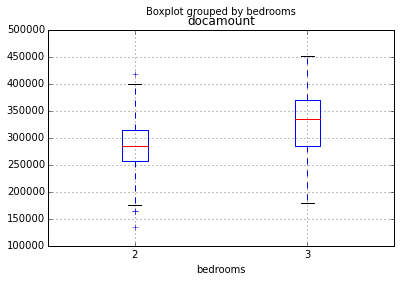

In [11]:
sales.boxplot(column='docamount',by='bedrooms')

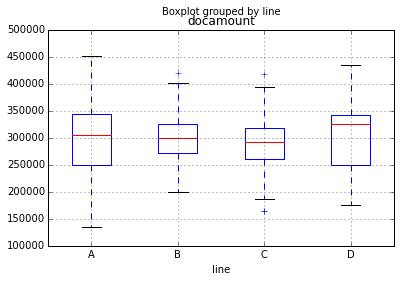

In [12]:
sales.boxplot(column='docamount',by='line')

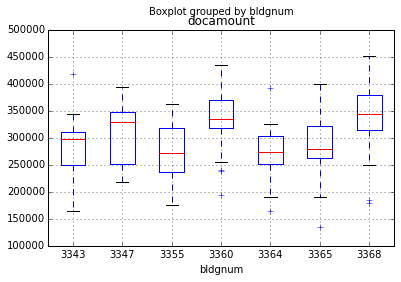

In [13]:
sales.boxplot(column='docamount',by='bldgnum')

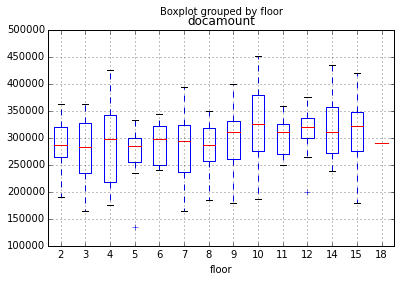

In [14]:
sales.boxplot(column='docamount',by='floor')

## Add in rolling and time weighted means

In [15]:
sales['rm']=pd.rolling_mean(sales.docamount,10,min_periods=1).shift(+1)

In [16]:
def time_weighted_mean(referencedate, data, nsamples=0):
    data=data[data.index<referencedate]
    if nsamples > 0:
        data=data.tail(nsamples)
    if len(data)==0:
        return np.nan
    diffs=(referencedate-data.index.values).astype('timedelta64[D]')
    maxdiff=max(diffs)
    weights=maxdiff-diffs
    if sum(weights)==0:
        return np.nan
    adjustedavg = np.average(data.docamount,weights=weights)
    return adjustedavg

In [17]:
sales['time_weighted_mean']=[time_weighted_mean(t,sales) for t in sales.index.values]

In [18]:
sales['time_weighted_mean10']=[time_weighted_mean(t,sales,10) for t in sales.index.values]

## Calculate rolling/weight means by bedrooms

In [19]:
out=[]
g = sales.groupby('bedrooms')
for name, group in g:
    group['br_time_weighted_mean']=[time_weighted_mean(t,group,10) for t in group.index.values]
    group['br_rm']=pd.rolling_mean(group.docamount,10,min_periods=1).shift(+1)
    out.append(group)
sales = pd.concat(out).sort_index()


/Users/helene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/helene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Plot of prices over time and rolling means

- Red line rolling mean of prior 10 sales
- Yellow line has exponential decay of sale prices (so more recent sales count more)

In [20]:
def colorfrombr(br):
    if br=='1':
        return 'g'
    if br=='2':
        return 'b'
    if br=='3':
        return 'r'
    else:
        return 'k'

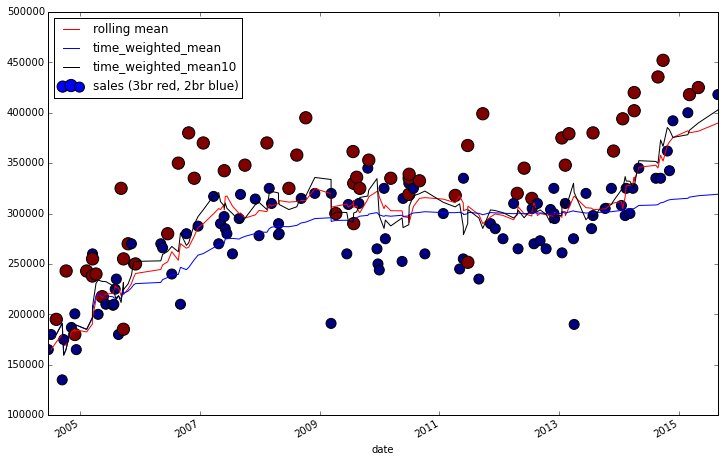

In [21]:
plt.figure(figsize=(12,8))
x=sales.index.values
y=sales.docamount
c=[int(s)*50 for s in sales.bedrooms]
plt.scatter(x,y,s=c,c=c,label='sales (3br red, 2br blue)')
sales.rm.plot(style='r',label='rolling mean')
sales.time_weighted_mean.plot(style='b')
sales.time_weighted_mean10.plot(style='k')
plt.legend(loc=2)
plt.show()

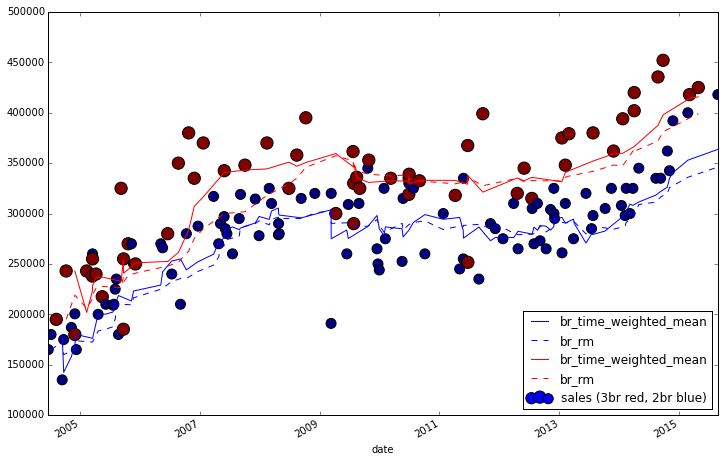

In [22]:
plt.figure(figsize=(12,8))
x=sales.index.values
y=sales.docamount
c=[int(s)*50 for s in sales.bedrooms]
plt.scatter(x,y,s=c,c=c,label='sales (3br red, 2br blue)')
g = sales.groupby('bedrooms')
for name, group in g:
    group.br_time_weighted_mean.plot(style='-',color=colorfrombr(name))
    group.br_rm.plot(style='--',color=colorfrombr(name))
plt.legend(loc=4)
plt.show()

### Prep for regression
- pull out missing values
- split data into train/test (by time)

In [23]:
sales = sales.dropna()
train=sales.head(round(len(sales)*.8))
test=sales.tail(round(len(sales)*.2))

/Users/helene/anaconda/lib/python2.7/site-packages/pandas/core/index.py:843: FutureWarning: slice indexers when using iloc should be integers and not floating point
  "and not floating point",FutureWarning)


### Regressions of prices based on prior sales, line floor and building number
 
- Not using any known information about bedrooms/buildings/views
- Provides good fit with adjusted R^2 = 0.728

Mean abs(residual):  32991.8194314 


                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.655     
Dependent Variable:    docamount           AIC:                   2810.0020 
Date:                  2015-11-23 22:32    BIC:                   2843.3515 
No. Observations:      119                 Log-Likelihood:        -1393.0   
Df Model:              11                  F-statistic:           21.38     
Df Residuals:          107                 Prob (F-statistic):    2.69e-22  
R-squared:             0.687               Scale:                 9.5785e+08
----------------------------------------------------------------------------
                   Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
----------------------------------------------------------------------------
Intercept         1101.9147 23088.5228  0.0477 0.9620 -44668.3889 46872.2183
line[T.B]        11985.8524  7849.3004  1.5270 0.1297  -3574

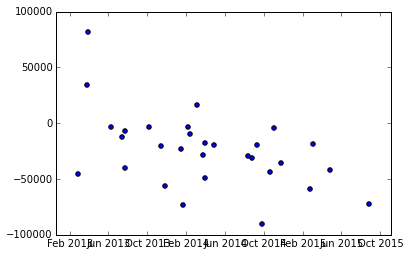

In [24]:
results = ols(formula="docamount ~ rm + line + floor + bldgnum", data=train).fit()
predictions = results.predict(exog=dict(rm=test.rm,line=test.line,floor=test.floor,bldgnum=test.bldgnum)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

## Regression - addding interaction for building-line

- Caution - these interaction terms leave fairly small group sizes, averaging around 5 and most as few as 2. 
- Only improves model very slightly to adjusted R^2 of 0.748, probably overfitting and not worth it 

bldgnum  line
3343     A       8
         B       8
         C       7
         D       5
3347     A       6
         B       3
         C       1
         D       2
3355     A       4
         B       5
         C       8
         D       5
3360     A       7
         B       5
         C       4
         D       8
3364     A       5
         B       5
         C       9
3365     A       8
         B       7
         C       6
         D       6
3368     A       7
         B       5
         C       2
         D       3
dtype: int64

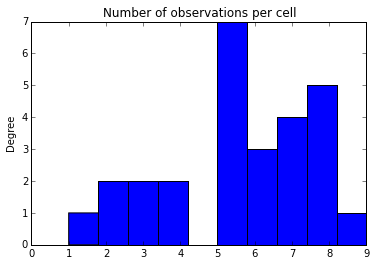

In [25]:
sales.groupby(['bldgnum','line']).size().plot(kind='hist',title='Number of observations per cell')
sales.groupby(['bldgnum','line']).size()

Mean abs(residual):  32067.2116571 


                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.691     
Dependent Variable:         docamount              AIC:                      2810.5222 
Date:                       2015-11-23 22:32       BIC:                      2891.1168 
No. Observations:           119                    Log-Likelihood:           -1376.3   
Df Model:                   28                     F-statistic:              10.40     
Df Residuals:               90                     Prob (F-statistic):       6.33e-18  
R-squared:                  0.764                  Scale:                    8.5951e+08
---------------------------------------------------------------------------------------
                             Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
---------------------------------------------------------------------------------------
Intercept             

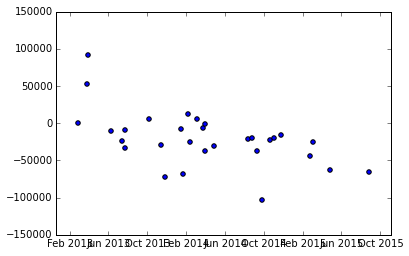

In [26]:
results = ols(formula="docamount ~ rm + line + floor + bldgnum + line*bldgnum", data=train).fit()
predictions = results.predict(exog=dict(rm=test.rm,line=test.line,floor=test.floor,bldgnum=test.bldgnum)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

### Regressions using rolling mean and know characteristics: bedrooms and skyline views

- Adjusted R^2 = 0.689
- Fairly strong but not as good as just using generic building, line and floor numbers
- View seems particularly bad, let's take out and put back in floor

Mean abs(residual):  30182.6319954 


                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.589     
Dependent Variable:   docamount          AIC:                  2823.5620 
Date:                 2015-11-23 22:32   BIC:                  2834.6785 
No. Observations:     119                Log-Likelihood:       -1407.8   
Df Model:             3                  F-statistic:          57.29     
Df Residuals:         115                Prob (F-statistic):   1.00e-22  
R-squared:            0.599              Scale:                1.1425e+09
-------------------------------------------------------------------------
                Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept     29809.9614 21757.8259  1.3701 0.1733 -13288.1043 72908.0270
bedrooms[T.3] 50639.1305  6771.1047  7.4787 0.0000  37226.8753 64051.3857
view[T.True]   3522.9

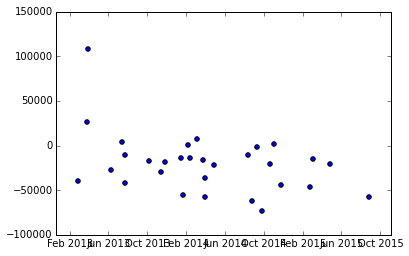

In [27]:
results = ols(formula="docamount ~ rm + bedrooms + view", data=train).fit()
predictions = results.predict(exog=dict(rm=test.rm,bedrooms=test.bedrooms,view=test.view)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

## Rolling mean bedrooms and floor

- Much better than my guess at view

Mean abs(residual):  29840.5211157 


                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.643     
Dependent Variable:   docamount          AIC:                  2806.8390 
Date:                 2015-11-23 22:32   BIC:                  2817.9555 
No. Observations:     119                Log-Likelihood:       -1399.4   
Df Model:             3                  F-statistic:          71.71     
Df Residuals:         115                Prob (F-statistic):   3.23e-26  
R-squared:            0.652              Scale:                9.9273e+08
-------------------------------------------------------------------------
                Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept      5168.8213 21124.0647  0.2447 0.8071 -36673.8853 47011.5279
bedrooms[T.3] 48265.3849  6049.6687  7.9782 0.0000  36282.1556 60248.6142
rm                0.8

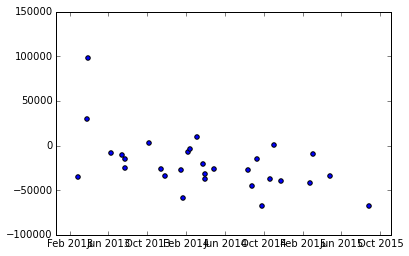

In [28]:
results = ols(formula="docamount ~ rm + bedrooms + floor", data=train).fit()
predictions = results.predict(exog=dict(rm=test.rm,bedrooms=test.bedrooms,floor=test.floor)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

## Adding back in building number to see if still matters with bedrooms in 

- One building still significant - possible explanations - center of complex, has management office in building , or just a few outlier sales? 
- But adjusted R-squared stays the same 

Mean abs(residual):  33303.5324437 


                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.651     
Dependent Variable:    docamount           AIC:                   2808.6746 
Date:                  2015-11-23 22:32    BIC:                   2833.6868 
No. Observations:      119                 Log-Likelihood:        -1395.3   
Df Model:              8                   F-statistic:           28.53     
Df Residuals:          110                 Prob (F-statistic):    1.44e-23  
R-squared:             0.675               Scale:                 9.6904e+08
----------------------------------------------------------------------------
                   Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
----------------------------------------------------------------------------
Intercept         9437.3486 22830.6374  0.4134 0.6801 -35807.6160 54682.3133
bedrooms[T.3]    29964.9523  6218.5169  4.8187 0.0000  17641

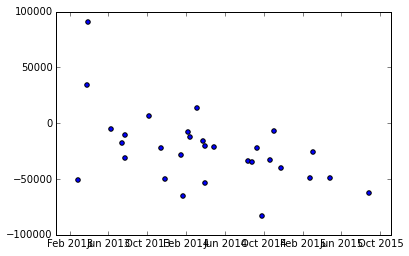

In [29]:
results = ols(formula="docamount ~ rm + bedrooms + floor + bldgnum", data=train).fit()
predictions = results.predict(exog=dict(rm=test.rm,bedrooms=test.bedrooms,floor=test.floor,bldgnum=test.bldgnum)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

## Time weighted mean instead of simple rollling mean

- No clear difference

Mean abs(residual):  29414.091958 


                         Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.613     
Dependent Variable:      docamount            AIC:                    2816.3684 
Date:                    2015-11-23 22:32     BIC:                    2827.4849 
No. Observations:        119                  Log-Likelihood:         -1404.2   
Df Model:                3                    F-statistic:            63.25     
Df Residuals:            115                  Prob (F-statistic):     3.15e-24  
R-squared:               0.623                Scale:                  1.0755e+09
--------------------------------------------------------------------------------
                       Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
--------------------------------------------------------------------------------
Intercept             5284.5256 22655.2399  0.2333 0.8160 -39591.1443 50160.1955
bedrooms[T.3]  

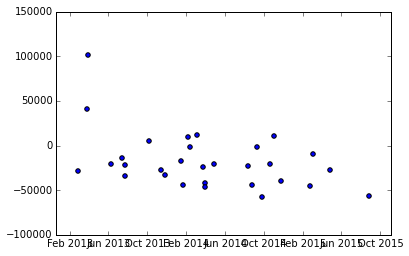

In [30]:
results = ols(formula="docamount ~ time_weighted_mean10 + bedrooms + floor", data=train).fit()
predictions = results.predict(exog=dict(time_weighted_mean10=test.time_weighted_mean10,bedrooms=test.bedrooms,floor=test.floor)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

## Bedroom specific rolling means

- Works, now bedroom variable no longer significant because that's captured by bedroom specific rolling mean

Mean abs(residual):  37409.983585 


                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.618     
Dependent Variable:   docamount         AIC:                 2814.7751 
Date:                 2015-11-23 22:32  BIC:                 2825.8916 
No. Observations:     119               Log-Likelihood:      -1403.4   
Df Model:             3                 F-statistic:         64.61     
Df Residuals:         115               Prob (F-statistic):  1.47e-24  
R-squared:            0.628             Scale:               1.0612e+09
-----------------------------------------------------------------------
                Coef.     Std.Err.     t    P>|t|    [0.025    0.975]  
-----------------------------------------------------------------------
Intercept     43434.3443 19233.3010  2.2583 0.0258 5336.8766 81531.8119
bedrooms[T.3] 13380.6881  6707.2607  1.9950 0.0484   94.8955 26666.4807
br_rm             0.7678     0.0672 11.4180 0.0

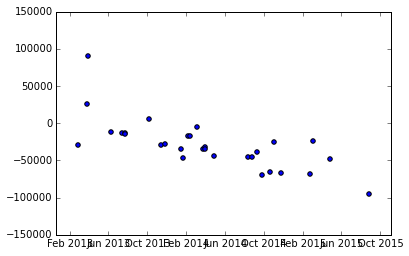

In [31]:
results = ols(formula="docamount ~ br_rm + bedrooms + floor", data=train).fit()
predictions = results.predict(exog=dict(br_rm=test.br_rm,bedrooms=test.bedrooms,floor=test.floor)) 
residuals = predictions - test.docamount
print 'Mean abs(residual): ', np.mean([abs(r) for r in residuals]),'\n\n'
print results.summary2()
plt.scatter(x=residuals.index,y=residuals.values)

In [32]:
# residuals growing over time - need to do adjustment for annual trend 

# leverage plot, look to see outlier influence 
# influence plot 
# fig, ax = plt.subplots(figsize=(12,8))
# fig = sm.graphics.influence_plot(prestige_model, ax=ax, criterion="cooks")
# http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/regression_plots.html
    
# stepwise regression 

# sklearn regression functions - have more built in functions 
# start with basic linear
# then look at ridge and lasso regression 
# from sklearn.preprocessing import scale  

# look at difference in price by year 